In [1]:
import gymnasium as gym
import numpy as np
import pandas
import seaborn as sns
import torch
from einops import einsum, pack, rearrange, repeat
from matplotlib import pyplot as plt
from torch import nn

from legato.nets import Perceptron, TransitionModel
from legato.sampler import PBallSampler

In [2]:
np_rng = np.random.default_rng(0)

In [3]:
# Load data from data.npz
data = np.load("../data.npz")
indices = np.load("../trained_net_params/indices.npz")
train_indices, test_indices = indices["train_indices"], indices["test_indices"]

observations_train = data["observations"][train_indices]
actions_train = data["actions"][train_indices]

observations_test = torch.tensor(data["observations"][test_indices], dtype=torch.float32, device="cuda")
actions_test = torch.tensor(data["actions"][test_indices], dtype=torch.float32, device="cuda")

In [4]:
# Load models
state_encoder = torch.load("../trained_net_params/state_encoder.pt")
action_encoder = torch.load("../trained_net_params/action_encoder.pt")
transition_model = torch.load("../trained_net_params/transition_model.pt")
state_decoder = torch.load("../trained_net_params/state_decoder.pt")
action_decoder = torch.load("../trained_net_params/action_decoder.pt")

In [5]:
flat_states = rearrange(observations_test, "... f -> (...) f")
flat_actions = rearrange(actions_test, "... f -> (...) f")

# SHuffle
flat_states = flat_states[np_rng.permutation(flat_states.shape[0])]
flat_actions = flat_actions[np_rng.permutation(flat_actions.shape[0])]

flat_states = flat_states[:2048]
flat_actions = flat_actions[:2048]

In [6]:
# Get stdev of encoded states and actions across each element
with torch.no_grad():
    encoded_states = state_encoder(flat_states)
    state_std = torch.std(encoded_states, dim=0)

    encoded_actions = action_encoder((flat_actions, flat_states))

    recovered_states = state_decoder(encoded_states)
    recovered_actions = action_decoder((encoded_actions, encoded_states))

    action_std = torch.std(encoded_actions, dim=0)

In [7]:
encoded_states

tensor([[-0.0135, -0.0225,  0.0675, -0.1916],
        [-0.0643, -0.0528,  0.0687, -0.0345],
        [ 0.0044,  0.0200, -0.0181, -0.0412],
        ...,
        [-0.0264, -0.0161,  0.0292, -0.0379],
        [-0.1187,  0.0251,  0.0711,  0.0012],
        [-0.0011,  0.0164,  0.0551, -0.0988]], device='cuda:0')

In [8]:
encoded_actions

tensor([[-0.1565, -0.2524],
        [-0.1521, -0.0638],
        [ 0.0124, -0.1767],
        ...,
        [-0.0318,  0.0548],
        [-0.4580, -0.0039],
        [-0.0816,  0.0516]], device='cuda:0')

In [9]:
print(f"State std: {state_std.cpu().numpy()}\nAction std: {action_std.cpu().numpy()}")

State std: [0.04744858 0.13936673 0.04072791 0.1820288 ]
Action std: [0.18414962 0.18388623]


In [10]:
transition_batch_size = 32
# Test forward model
traj_inds = torch.randint(
    0, observations_test.shape[0], (transition_batch_size,), device="cuda"
)
test_start_inds = torch.randint(
    0, int(observations_test.shape[-2] // 1.1), (transition_batch_size,), device="cuda"
)

test_states = observations_test[traj_inds]
test_actions = actions_test[traj_inds]

start_states = observations_test[traj_inds, test_start_inds]

In [11]:
start_states.shape

torch.Size([32, 4])

In [12]:
latent_start_states = state_encoder(start_states)

latent_traj_actions = action_encoder((test_actions, test_states))

latent_pred_fut_states = transition_model(
    latent_start_states, latent_traj_actions, start_indices=test_start_inds
)

In [13]:
latent_fut_states = state_encoder(test_states)

traj_ind = traj_inds[0]
start_ind = test_start_inds[0]

latent_fut_states_select = latent_fut_states[0, start_ind:]
latent_pred_fut_states_select = latent_pred_fut_states[0, start_ind:]

In [14]:
torch.stack([latent_fut_states_select, latent_pred_fut_states_select], dim=-1)

tensor([[[-4.3865e-02, -1.7419e-02],
         [-3.2005e-02,  1.1075e-02],
         [ 7.5339e-02,  4.2600e-02],
         [-2.5303e-02,  1.8603e-02]],

        [[-4.0423e-02, -1.9880e-02],
         [-3.0041e-02,  1.0099e-02],
         [ 7.5624e-02,  4.5895e-02],
         [-2.3268e-02,  1.4663e-02]],

        [[-3.4792e-02, -2.1618e-02],
         [-3.2092e-02,  5.5645e-03],
         [ 7.5129e-02,  4.8049e-02],
         [-2.4679e-02,  1.3932e-02]],

        ...,

        [[ 6.9019e-02, -1.5490e-03],
         [-1.5825e-02, -1.2183e-02],
         [ 8.1286e-02,  3.2718e-02],
         [-7.0640e-01,  2.8190e-03]],

        [[ 7.6870e-02,  2.1029e-03],
         [-2.8497e-02, -1.3064e-02],
         [ 7.6120e-02,  3.1967e-02],
         [-7.6268e-01,  5.5375e-04]],

        [[ 7.3123e-02, -5.2277e-03],
         [-3.8639e-02, -1.8099e-02],
         [ 6.5168e-02,  2.9946e-02],
         [-7.4172e-01,  4.3458e-04]]], device='cuda:0',
       grad_fn=<StackBackward0>)

In [15]:
# Measure error per time into the future

time_into_future = torch.arange(
    latent_fut_states.shape[-2], device="cuda"
)[None] - test_start_inds[..., None]

In [16]:
mae_errors = torch.mean(
    torch.abs(latent_fut_states - latent_pred_fut_states), dim=-1
)

In [17]:
mae_errors_flat = rearrange(mae_errors, "... -> (...)").detach().cpu().numpy()
time_into_future_flat = (
    rearrange(time_into_future, "... -> (...)").detach().cpu().numpy()
)

df = pandas.DataFrame.from_dict(
    {"mae_error": mae_errors_flat, "time_into_future": time_into_future_flat},
)
df = df[df["time_into_future"] >= 0]

(0.0, 1024.0)

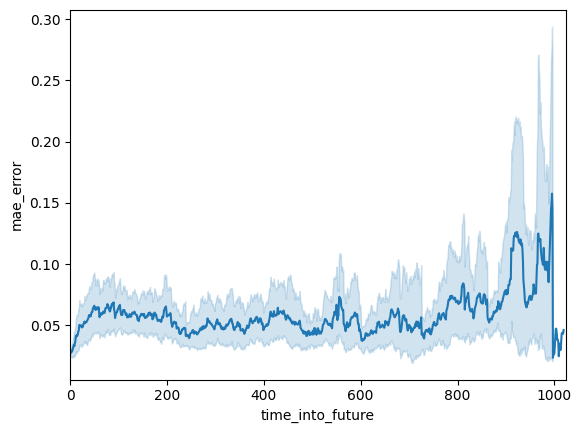

In [18]:
fig, ax = plt.subplots()
sns.lineplot(data=df, x="time_into_future", y="mae_error", ax=ax)
ax.set_xlim(0, 1024)

In [19]:
latent_state_sampler = PBallSampler(
    4, 1, 2.0, device="cuda"
)

In [20]:
latent_states = state_encoder(flat_states[:512])

In [21]:
class CoverageLoss(nn.Module):

    def __init__(
        self,
        latent_sampler,
        norm_p=1,
        latent_samples=2048,
        selection_tail_size=4,
        far_sample_count=64,
        pushing_sample_size=4,
        loss_function=nn.L1Loss(),  # nn.HuberLoss(),
    ):
        super().__init__()

        self.latent_sampler = latent_sampler
        self.norm_p = norm_p
        self.latent_samples = latent_samples
        self.selection_tail_size = selection_tail_size
        self.far_sample_count = far_sample_count
        self.pushing_sample_size = pushing_sample_size
        self.loss_function = loss_function

    def forward(self, latents):
        # penalize for empty space within the state space
        # Sample random points in the latent space

        proposals = self.latent_sampler(self.latent_samples)
        points = torch.cat([proposals, latents], dim=0)
        distances = torch.cdist(proposals, points, p=self.norm_p)

        in_point_mask = torch.zeros(
            len(points), dtype=torch.bool, device=latents.device
        )
        in_point_mask[self.latent_samples :] = True
        in_point_mask[self.latent_samples :] = True
        far_samples = torch.zeros(
            self.far_sample_count,
            latents.shape[-1],
            dtype=latents.dtype,
            device=latents.device,
        )
        for i in range(self.far_sample_count):
            in_point_dists = distances[:, in_point_mask]
            tail_distances = torch.topk(
                in_point_dists, self.selection_tail_size, dim=-1, largest=False
            ).values.mean(-1)
            # Mask out already selected points
            tail_distances[in_point_mask[: self.latent_samples]] = -torch.inf
            farthest_index = torch.topk(tail_distances, 1, dim=-1).indices
            in_point_mask[farthest_index] = True
            far_samples[i] = proposals[farthest_index]

        # Now make the states by the latent states closer to the farthest samples
        empty_space_dists = torch.cdist(far_samples, latents, p=self.norm_p)
        close_empty_space_dists = torch.topk(
            empty_space_dists, self.pushing_sample_size, dim=-1, largest=False
        ).values.mean(-1)
        space_coverage_loss = self.loss_function(
            close_empty_space_dists, torch.zeros_like(close_empty_space_dists)
        ).mean()

        return far_samples

In [22]:
scl = CoverageLoss(latent_state_sampler, norm_p=1, latent_samples=16_384, selection_tail_size=4, far_sample_count=64, pushing_sample_size=4)

In [23]:
far_samples = scl(latent_states)
sdf = pandas.DataFrame.from_records(
    np.concatenate(
        [
            np.concatenate(
                [
                    latent_states.detach().cpu().numpy(),
                    np.zeros((len(latent_states), 1)),
                ],
                axis=1,
            ),
            np.concatenate(
                [
                    far_samples.detach().cpu().numpy(),
                    np.ones((len(far_samples), 1)),
                ],
                axis=1,
            ),
        ],
    ),
    columns=["e0", "e1", "e2", "e3", "samp"],
)

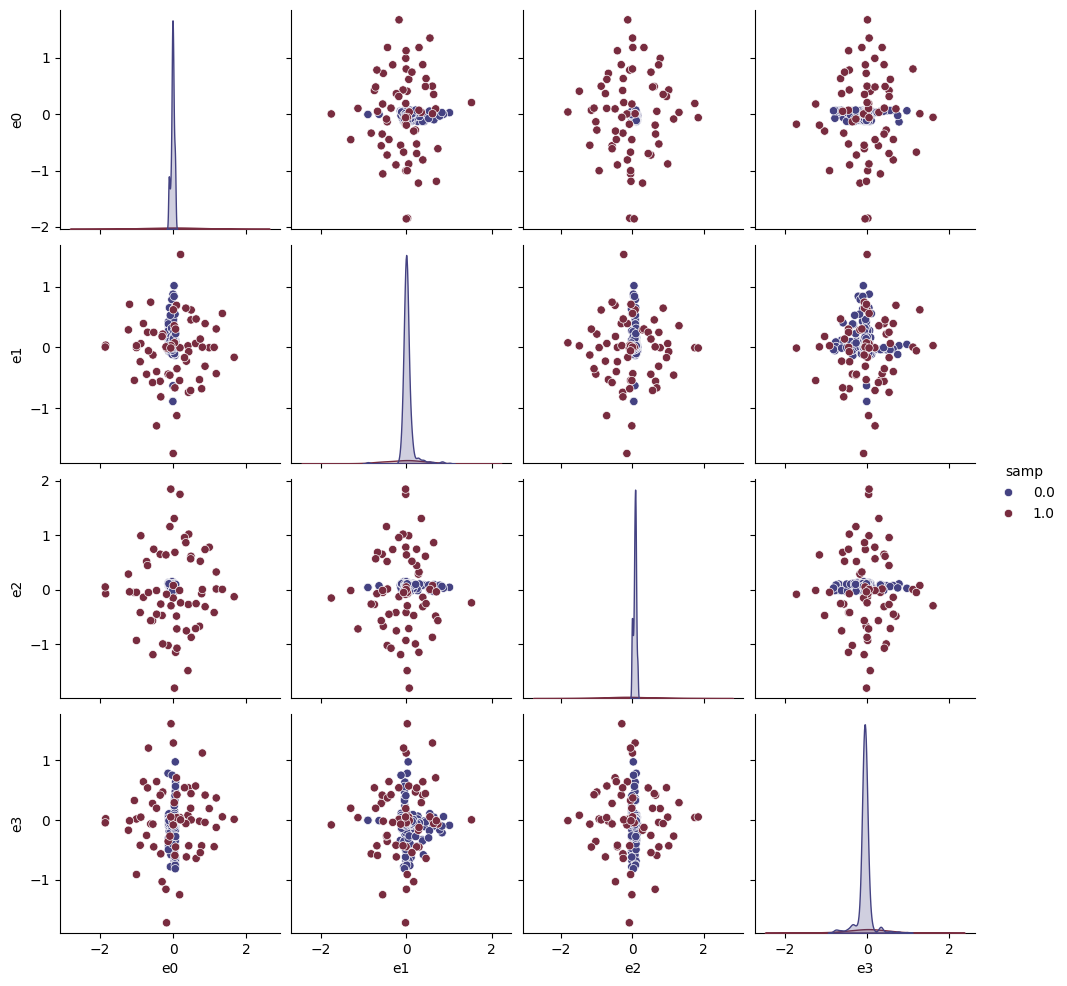

In [24]:
sns.pairplot(sdf, hue="samp", palette="icefire")

In [25]:
latent_action_sampler = PBallSampler(
    2, 1, 1.0, device="cuda"
)

In [26]:
latent_actions = action_encoder((flat_actions[:512], flat_states[:512]))

In [27]:
acl = CoverageLoss(latent_action_sampler, norm_p=1, latent_samples=16_384, selection_tail_size=4, far_sample_count=64, pushing_sample_size=4)

In [28]:
far_samples = acl(latent_actions)
adf = pandas.DataFrame.from_records(
    np.concatenate(
        [
            np.concatenate(
                [
                    latent_actions.detach().cpu().numpy(),
                    np.zeros((len(latent_actions), 1)),
                ],
                axis=1,
            ),
            np.concatenate(
                [
                    far_samples.detach().cpu().numpy(),
                    np.ones((len(far_samples), 1)),
                ],
                axis=1,
            ),
        ],
    ),
    columns=["e0", "e1", "samp"],
)

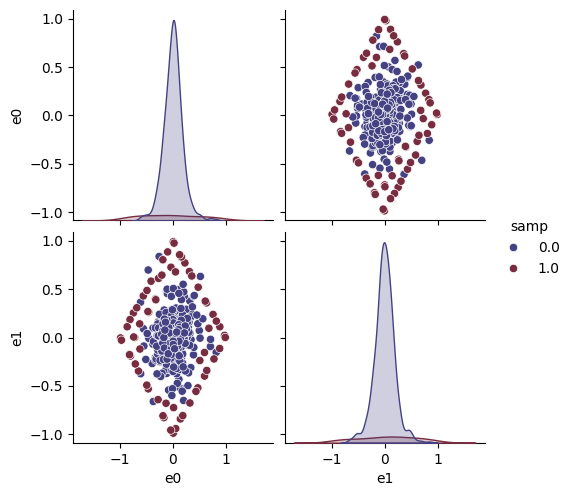

In [29]:
sns.pairplot(adf, hue="samp", palette="icefire")